## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [ ]:
df=pd.read_csv('/content/drive/My Drive/OIL/oildata.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["DATE"] = pd.to_datetime(df["DATE"])

df.head(2)

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        1254 non-null   datetime64[ns]
 1   DCOILWTICO  1254 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.7 KB


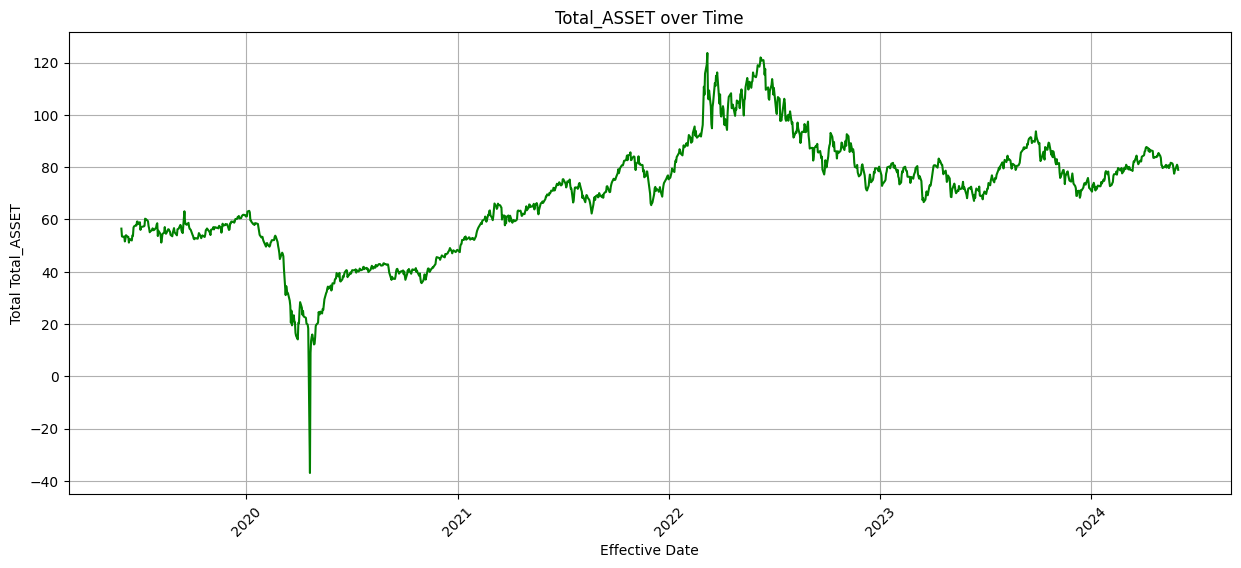

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['DCOILWTICO'],  linestyle='-',color='green')
plt.xlabel('Effective Date')
plt.ylabel('Total Total_ASSET')
plt.title('Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
df.set_index('DATE', inplace=True)

df.head()

,DCOILWTICO
DATE,
2019-05-30,56.47
2019-05-31,53.49
2019-06-03,53.25
2019-06-04,53.50
2019-06-05,51.57


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1254 entries, 2019-05-30 to 2024-05-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DCOILWTICO  1254 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [ ]:
train = df[:770]
valid = df[770:1100]
test = df[1100:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['DCOILWTICO']])
validate_data = scaler.transform(valid[['DCOILWTICO']])
test_data = scaler.transform(test[['DCOILWTICO']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))



Train data size: 770
Validation data size: 330
Test data size: 154


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=264, kernel_size=3, activation='relu', input_shape=(10, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

from tensorflow.keras.optimizers import Adam

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.005)

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='mse')
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0361 - val_loss: 0.0012
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 5.8376e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7789e-04 - val_loss: 0.0013
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5748e-04 - val_loss: 7.5379e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 5.5453e-04
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 5.5577e-04
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 5.8155e-04
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for training and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
test_rmse = sqrt(mean_squared_error(y_val, test_predict))

# Calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_val, test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')



Train RMSE: 3.4391443092208656
Test RMSE: 2.7918608163253813
Train MSE: 11.827713579646264
Test MSE: 7.794486817733025


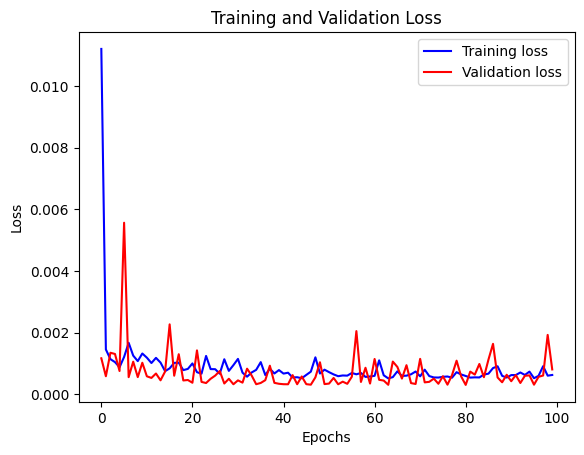

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]  # Retrieve validation loss
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")  # Plot validation loss with red color

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



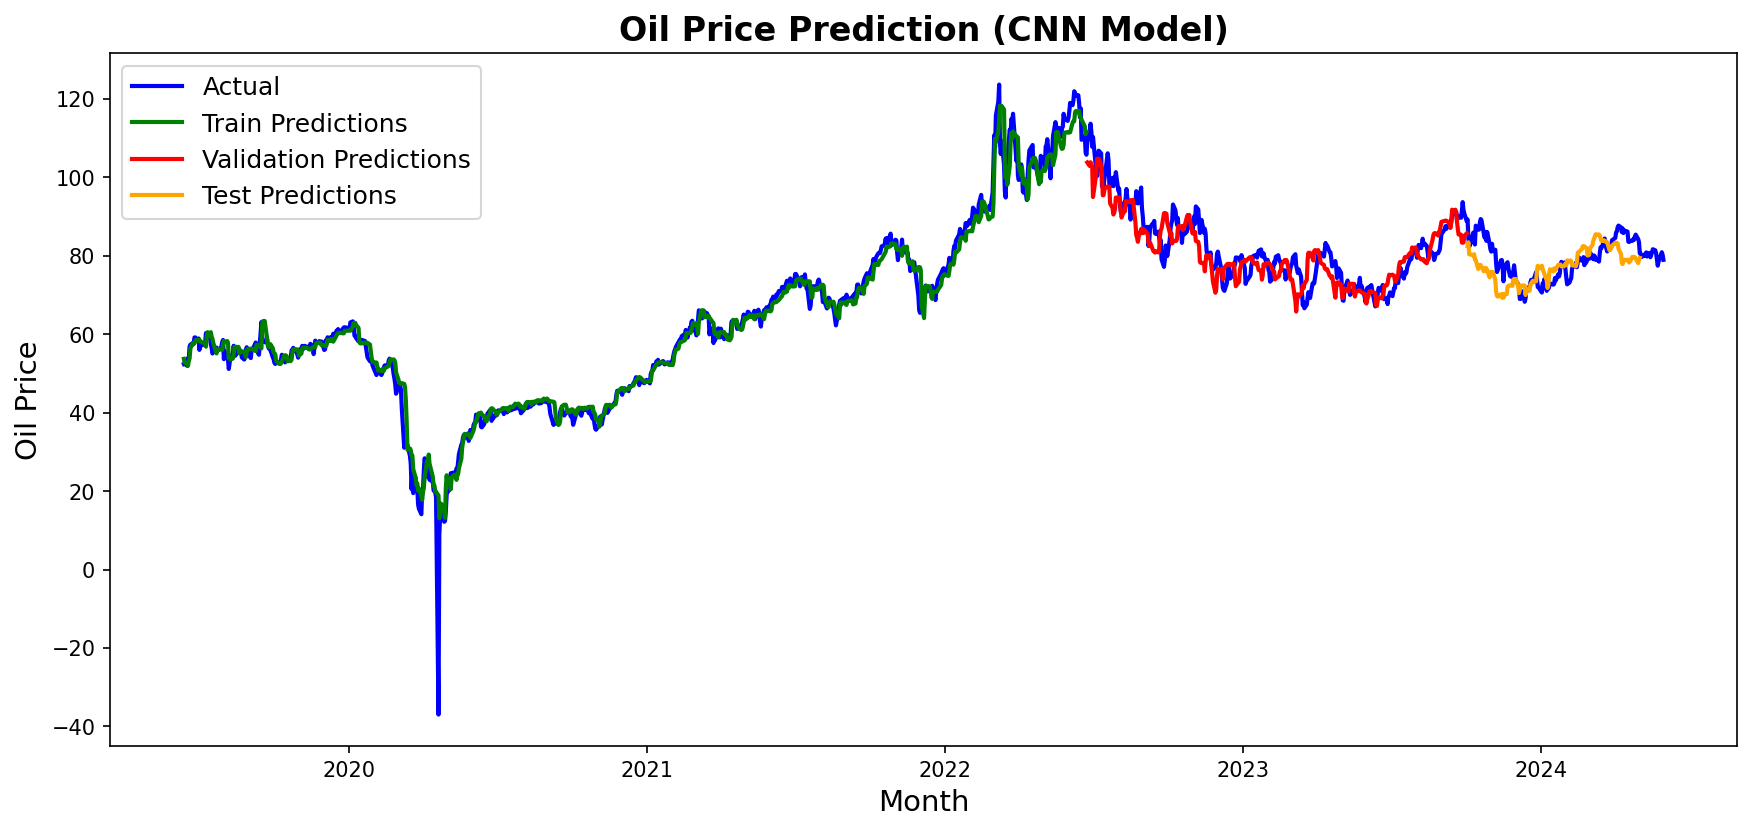

In [ ]:
import matplotlib.pyplot as plt

# Adjust figure size and DPI for higher quality
plt.figure(figsize=(14, 6), dpi=150)  # Increased DPI for better resolution

# Plot the actual and predicted values with thicker lines and larger labels
plt.plot(df.index[seq_length:], df['DCOILWTICO'][seq_length:], label='Actual', color='blue', linewidth=2)

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green', linewidth=2)

# Index ranges for validation and test predictions
val_pred_index = range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red', linewidth=2)

test_pred_index = range(seq_length + len(train_predictions) + len(val_predictions), seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange', linewidth=2)

# Set titles and labels with larger fonts
plt.title('Oil Price Prediction (CNN Model)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Oil Price', fontsize=14)

# Add a larger legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()
